<a href="https://colab.research.google.com/github/aguschanchu/FermionicML/blob/main/FermionicML_thermal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FermionicML:

Code based on aguschanchu/Bosonic.py

A diferencia del código anterior, este modelo trabaja sobre estados térmicos

## Código base

Cargamos el código de Bosonic.py básico, branch fermionic

In [2]:
import numpy as np
from scipy.special import binom
from scipy.sparse import dok_matrix, linalg
from scipy import linalg as linalg_d
from joblib import Memory
import random
import plotly.graph_objects as go
from joblib import Parallel, delayed
from numba import jit, prange, njit
import numba as nb
import pickle
import math
import tensorflow_probability as tfp
import tensorflow as tf
from tqdm import tqdm
from itertools import combinations


# Funciones auxiliares optimiadas
@nb.jit(nopython=True, parallel=True)
def int_to_tuple_arr(ni,nf, b, digits=None):
    sol = np.zeros((nf-ni, digits), dtype=np.int64)
    for n in prange(ni, nf):
        r = np.zeros(digits, dtype=np.int64)
        ncop = n
        idx = 0
        while n != 0:
            r[idx] = n % b
            n = n // b
            idx += 1
        if digits is not None:
            if idx < digits:
                for i in range(idx, digits):
                    r[i] = 0
                idx = digits
        sol[ncop-ni,:] = r[:idx]
    return sol

def tuple_to_int(t, d):
    b = d-1
    l = len(t)
    s = [t[k]*b**(l-k-1) for k in range(0,l)]
    return sum(s)

def create_basis_(m, d, size):
    base = []
    index = 0
    chunk_size = 1000000
    for x in range(0,(m+1)**d, chunk_size):
        start_index = x
        end_index = min(x + chunk_size, (m+1)**d)
        arr = int_to_tuple_arr(start_index, end_index, m+1, d)
        sums = np.sum(arr, axis=1)
        rows = np.where(sums == m)[0]
        for row in [arr[i] for i in rows]:
            if np.all(np.logical_or(row == 0, row == 1)):
                base.append(row)

    # Como consecuencia de la paralelizacion, es necesario reordenar la base
    sorted_base = sorted(base, key=lambda x: tuple_to_int(x, d), reverse=True)
    assert len(base) == size

    return sorted_base

def custom_base_representation_tf(n_min, n_max, base, num_digits):
    # Generate a range of numbers from n_min to n_max
    numbers = tf.range(n_min, n_max + 1, dtype=tf.int64)
    
    # Calculate the digits in the custom base using broadcasting
    digits = tf.pow(tf.cast(base, dtype=tf.float64), tf.cast(tf.range(num_digits), dtype=tf.float64))
    
    # Reshape the digits to [1, num_digits] for broadcasting
    digits = tf.reshape(digits, [1, -1])
    
    # Reshape numbers to [batch_size, 1]
    numbers = tf.reshape(tf.cast(numbers, dtype=tf.float64), [-1, 1])
    
    # Calculate the digits in the custom base for each number using broadcasting
    result = tf.cast(tf.math.floormod(tf.math.floordiv(numbers, digits), base), dtype=tf.int32)
    
    # Pad the result to have exactly num_digits columns
    result = tf.pad(result, paddings=[[0, 0], [0, num_digits - tf.shape(result)[1]]], constant_values=0)
    
    # Reverse the order of columns
    #result = tf.reverse(result, axis=[1])

    return result

def select_rows_with_sum(arr, m):
    # Create a mask based on the criteria
    mask = tf.reduce_all(tf.math.logical_or(tf.equal(arr, 0), tf.equal(arr, 1)), axis=1) & (tf.reduce_sum(arr, axis=1) == m)
    
    # Use the mask to select the rows
    result = tf.boolean_mask(arr, mask, axis=0)
    
    return result

def create_basis_tf_(m, d):
    base = []
    index = 0
    chunk_size = 10000000
    for x in tqdm(range(0,(m+1)**d, chunk_size)):
        start_index = x
        end_index = min(x + chunk_size, (m+1)**d)
        res = custom_base_representation_tf(start_index, end_index, m+1, d)
        arr = select_rows_with_sum(res, m)
        base.append(arr.numpy())

    return np.concatenate(base)

def create_fermionic_base_(m, d):
    indices = list(range(d))
    combinations_list = list(combinations(indices, m))
    
    vectors = []
    for combo in combinations_list:
        vector = [1 if i in combo else 0 for i in indices]
        vectors.append(vector)
    
    return vectors

# Dada una base, devuelve los vectores que estan dados de a pares
def get_kkbar_indices_(base):
    indices = []
    for i, v in enumerate(base):
        if np.all(v[::2] == v[1::2]):
            indices.append(i)
    return indices

class fixed_basis:

    # Convierte a un enterno n a su escritura en base b
    def _int_to_tuple(self, n, b, digits = None):
        rep = np.base_repr(n, b)
        rep_int = [int(x,b) for x in rep]
        if digits is not None:
            zeros = [0 for i in range(0,digits-len(rep))]
            return zeros + rep_int
        else:
            return rep_int

    # Revierte la transformacion anterior
    def tuple_to_int(self, t):
        b = self.d-1
        l = len(t)
        s = [t[k]*b**(l-k-1) for k in range(0,l)]
        return sum(s)

    # Convierte el vector en su representacion
    def vect_to_repr(self, vect):
        for i, k in enumerate(vect):
            if k == 1. or k == 1:
                break
        else:
            return 0
        return self.base[i,:]

    def rep_to_vect(self, rep):
        rep = list(rep)
        for i, r in [(j, self.base[j,:]) for j in range(0,self.size)]:
            if list(r) == rep:
                return self.canonicals[:,i]
        else:
            None

    def rep_to_index(self, rep):
        try:
            return self.base.tolist().index(list(rep))
        except:
            return None

    @staticmethod
    def rep_to_exi(rep):
        r = []
        for i, k in enumerate(rep):
            r += [i for x in range(0,k)]
        return r

    # Crea base de M particulas en D estados (repr y base canonica)
    def create_basis(self, m, d, pairs = False):
        #print("Creating basis: ", m, d)
        #base = np.array(create_basis_tf_(m, d)) CASO GENERICO
        base = np.array(create_fermionic_base_(m,d)) # UNICAMENTE FERMIONICO
        if pairs:
            base = base[get_kkbar_indices_(base)]
        length = base.shape[0]
        # Asignamos a cada uno de ellos un canónico
        canonicals = np.eye(length)
        return base, canonicals
    
    def __init__(self, m, d, pairs = False):
        self.m = m
        self.d = d
        (self.base, self.canonicals) = self.create_basis(m, d, pairs)
        self.size = self.base.shape[0]

# Matrices de aniquilación y creación endomórficas. Estan fuera de la clase para poder ser cacheadas
#@memory.cache
def bdb(basis, i, j):
    mat = dok_matrix((basis.size, basis.size), dtype=np.float32)
    if i != j:
        for k, v in enumerate(basis.base):
            if v[j] != 0 and v[i] != 1:
                #print(v)
                dest = list(v.copy())
                dest[j] -= 1
                dest[i] += 1
                tar = basis.rep_to_index(dest)
                if tar is None:
                    pass
                else:
                    mat[tar, k] = np.sqrt(v[i]+1)*np.sqrt(v[j])
    else:
        for k, v in enumerate(basis.base):
            if v[j] != 0:
                mat[k, k] = v[i] 
    return mat

#@memory.cache
def bbd(basis, i, j):
    mat = dok_matrix((basis.size, basis.size), dtype=np.float32)
    if i != j:
        for k, v in enumerate(basis.base):
            if v[i] != 0 and v[j] != 1:
                dest = list(v.copy())
                dest[i] -= 1
                dest[j] += 1
                tar = basis.rep_to_index(dest)
                mat[tar, k] = np.sqrt(v[j]+1)*np.sqrt(v[i])
    else:
        for k, v in enumerate(basis.base):
            if v[i] != 1:
                mat[k, k] = v[i]+1
    return mat

# Matrices de aniquilación y creación.Toman la base de origen y destino (basis_o, basis_d) resp
#@nb.jit(nopython=True, parallel=True)
@nb.jit(nopython=True)
def b_aux(basis_o, basis_d, i):
    mat = np.zeros((len(basis_d), len(basis_o)), dtype=np.float32)
    for k in prange(len(basis_o)):
        if basis_o[k][i] != 0:
            dest = list(basis_o[k].copy())
            dest[i] -= 1
            for j in prange(len(basis_d)):
                if list(basis_d[j]) == dest:
                    tar = j
                    mat[tar, k] = np.sqrt(basis_o[k][i])
    return mat

def b(basis_o, basis_d, i):
    return b_aux(basis_o.base, basis_d.base, i)

#@nb.jit(nopython=True, parallel=True)
@nb.jit(nopython=True)
def bd_aux(basis_o, basis_d, i):
    mat = np.zeros((len(basis_d), len(basis_o)), dtype=np.float32)
    for k in prange(len(basis_o)):
        if basis_o[k][i] != 1:
            dest = list(basis_o[k].copy())
            dest[i] += 1
            for j in prange(len(basis_d)):
                if list(basis_d[j]) == dest:
                    tar = j
                    mat[tar, k] = np.sqrt(basis_o[k][i]+1)
    return mat

def bd(basis_o, basis_d, i):
    return bd_aux(basis_o.base, basis_d.base, i)


# Acepta una lista de indices a crear
@nb.jit(nopython=True, parallel=True)
def bd_gen_aux(basis_o, basis_d, gen_list):
    mat = np.zeros((len(basis_d), len(basis_o)), dtype=np.float32)
    for k in prange(len(basis_o)):
        conds = np.zeros(len(gen_list), dtype=np.int64)
        for i in range(len(gen_list)):
            if basis_o[k][gen_list[i]] != 1:
                conds[i] = 1
        if np.all(conds):
            dest = list(basis_o[k].copy())
            for i in gen_list:
                dest[i] += 1
            for j in prange(len(basis_d)):
                if list(basis_d[j]) == dest:
                    tar = j
                    mat[tar, k] = np.sqrt(basis_o[k][i]+1)
    return mat

def bd_gen(basis_o, basis_d, i):
    return bd_gen_aux(basis_o.base, basis_d.base, np.array(i))

def b_gen(basis_o, basis_d, i):
    return np.transpose(bd_gen(basis_d, basis_o, i))

# Volvemos a definir la función para compilarla
@nb.jit(forceobj=True)
def _rep_to_index(base, rep):
    return base.tolist().index(list(rep))

# Funciones auxiliares para calcular rho2kkbar y gamma_p
@nb.jit(nopython=True)
def rep_to_exi(rep):
    r = []
    for i in range(len(rep)):
        for j in range(rep[i]):
            r.append(i)
    return r

@nb.njit
def factorial(n):
    result = 1
    for i in range(1, n + 1):
        result *= i
    return result

@nb.njit
def gamma_lamba(x):
    res = 1.0
    for o in x:
        res *= math.sqrt(factorial(o))
    return res

@nb.jit
def gamma_lamba_inv(x):
    res = 1.0
    for o in x:
        res *= 1.0 / np.sqrt(factorial(o))
    return res

@nb.njit
def rep_to_index_np(base, rep):
    for i in range(len(base)):
        if np.all(base[i] == rep):
            return i
    return -1


def gamma_p(basis, m, vect, m_basis = None, nm_basis = None):
    d = basis.d
    if not m_basis or not nm_basis:
        m_basis = fixed_basis(m, d)
        nm_basis = fixed_basis(basis.m-m,d)
    return gamma_p_aux(basis.base, vect, m_basis.base, nm_basis.base)

@nb.njit()
def gamma_p_aux(basis, vect, m_basis, nm_basis):
    mat = np.zeros((len(m_basis), len(nm_basis)), dtype=np.float32)
    for i in prange(len(m_basis)):
        v = m_basis[i]
        for j in prange(len(nm_basis)):
            w = nm_basis[j]
            targ = v + w
            index = rep_to_index_np(basis, targ)
            if index != -1:
                coef = vect[index]
                if coef != 0:
                    coef = coef * gamma_lamba_inv(v) * gamma_lamba_inv(w) * gamma_lamba(targ)
                mat[i, j] = coef
    return mat
# Devuelve la matriz rho M asociada al vector
def rho_m(basis, m, vect, m_basis = None, nm_basis = None):
    g = gamma_p(basis, m, vect, m_basis, nm_basis)
    return np.dot(g,np.transpose(g))

# Devuelve la matriz gamma asociada a la descomposición (M,N-M) del vector
@jit(forceobj=True)
def gamma(basis, m, vect, m_basis = None, nm_basis = None):
    d = basis.d
    if not m_basis or not nm_basis:
        m_basis = fixed_basis(m, d)
        nm_basis = fixed_basis(basis.m-m,d)
    mat = dok_matrix((m_basis.size, nm_basis.size), dtype=np.float32)
    for i, v in enumerate(m_basis.base):
        for j, w in enumerate(nm_basis.base):
            targ = v+w
            # Revisamos que sea un estado fermionico valido
            arr = np.asarray(targ)
            if not np.all(np.logical_or(arr == 0, arr == 1)):
                continue
            index = _rep_to_index(basis.base, targ)
            coef = vect[index]
            if coef != 0:
                aux = lambda x: np.prod(np.reciprocal(np.sqrt([np.math.factorial(o) for o in x])))
                aux_inv = lambda x: np.prod(np.sqrt([np.math.factorial(o) for o in x]))
                coef = coef * aux(v) * aux(w) * aux_inv(targ)
                #coef = coef
                #print(v,w,coef)
            mat[i,j] = coef
    return mat

# Genera las matrices de rho1
def rho_1_gen(basis):
    d = basis.d
    s = basis.size
    mat = np.empty((d,d,s,s), dtype=np.float32)
    for i in range(0, d):
        for j in range(0, d):
            mat[i,j,:,:] = np.array(bdb(basis,j, i).todense())
    return mat

#@jit(parallel=True, nopython=True)
def rho_1(d, state, rho_1_arrays):
    state_expanded = state[np.newaxis, np.newaxis, :, :]
    product = state_expanded * rho_1_arrays
    mat = np.sum(product, axis=(-2, -1))

    return mat


# Genera las matrices de rho2
def rho_2_gen(basis, mll_basis, t_basis):
    size = t_basis.size
    s = basis.size
    # La entrada i, j contiene C_j^\dag C_i    i, j \in t_basis
    mat = np.empty((size, size, s, s), dtype=np.float32)
    for i, v in enumerate(t_basis.base):
        for j, w in enumerate(t_basis.base):
            c_i = b_gen(basis, mll_basis, rep_to_exi(v))
            cdag_j = bd_gen(mll_basis, basis, rep_to_exi(w))
            mat[i, j, :, :] = np.dot(cdag_j, c_i)

    return mat

def rho_2(size, state, rho_2_arrays):
    state_expanded = np.expand_dims(state, axis=1)
    state_expanded = np.expand_dims(state_expanded, axis=1)
    rho_2_arrays = rho_2_arrays[np.newaxis, :, :, :, :]
    print(state_expanded.shape, rho_2_arrays.shape)
    product = state_expanded * rho_2_arrays
    mat = np.sum(product, axis=(-2, -1))
    return mat

def get_kkbar_indices(t_basis):
    indices = []
    for i, v in enumerate(t_basis.base):
        if np.all(v[::2] == v[1::2]):
            indices.append(i)
    return indices

def rho_2_kkbar_gen(t_basis, rho_2_arrays):
    indices = get_kkbar_indices(t_basis)
    i, j = np.meshgrid(indices, indices, indexing='ij') # Lo usamos para rellenar la mat deseada

    rho_2_arrays_kkbar = rho_2_arrays[i, j, :, :]

    return rho_2_arrays_kkbar

# Devuelve la matriz rho 2 asociada al bloque kkbar
def rho_2_kkbar(basis, vect, ml_basis = None, mll_basis = None, t_basis = None):
    d = basis.d
    # Creo las bases si no están dadas
    if ml_basis == None or mll_basis == None or t_basis == None:
        ml_basis = fixed_basis(m-1,d)
        mll_basis = fixed_basis(m-2,d)
        t_basis = fixed_basis(2,d)
    diag = []
    for v in t_basis.base:
        for j in range(0, d, 2):
            if v[j] == v[j+1]:
                continue
            else:
                break
        else:
            diag.append(v)
    diag = np.array(diag)
    return rho_2_kkbar_aux(diag, vect, basis.base, ml_basis.base, mll_basis.base, t_basis.base)

@nb.njit
def rho_2_kkbar_lambda(x):
    res = 1.0
    for o in x:
        res *= 1.0 / math.sqrt(factorial(o))
    return res

#@nb.njit(parallel=True)
def rho_2_kkbar_aux(diag, vect, basis, ml_basis, mll_basis, t_basis):
    mat = np.zeros((len(diag), len(diag)), dtype=np.float32)
    for i in prange(len(diag)):
        for j in prange(len(diag)):
            v = diag[i]
            w = diag[j]
            # Creacion de los a
            i_set = rep_to_exi(v)
            b_m = b_aux(ml_basis, mll_basis, i_set[1]) @ b_aux(basis, ml_basis, i_set[0])
            # Creacion de los ad
            i_set = rep_to_exi(w)
            bd_m = bd_aux(ml_basis, basis, i_set[1]) @ bd_aux(mll_basis, ml_basis, i_set[0])
            # v1 = vect @ bd_m @ b_m @ vect Para estados puros
            # Mult de b's y filleo de mat
            coef = np.trace(vect @ bd_m @ b_m)
            mat[i,j] = coef * rho_2_kkbar_lambda(v) * rho_2_kkbar_lambda(w)
    return mat


2024-01-15 14:04:37.129704: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-15 14:04:37.179097: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 14:04:37.179130: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-15 14:04:37.179156: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-15 14:04:37.188049: I tensorflow/core/platform/cpu_feature_g

## Definicion de Hamiltoniano

Cargamos el código de creación y resolución de Hamiltonianos

In [3]:
m = 8
d = 2*m
pairs = True # Usar solo para estados puros
# Creo las bases para no tener que recrearlas luego
basis = fixed_basis(m, d, pairs = pairs)
#basis_m1 = fixed_basis(m-1, d, pairs = True)
basis_m2 = fixed_basis(m-2, d, pairs = pairs)
print(basis.size)

70


In [4]:
## Usamos este approach si queremos guardar los generadores
# Dados 1/2 (d^2+d) elementos, genera una mat de dxd:
eps = 0.00001

def sym_mat_gen(vect, d):
    matrix = fill_matrix(vect, d)
    return matrix + matrix.T - np.diag(matrix.diagonal())

@jit(nopython=True)
def fill_matrix(vect, d):
    matrix = np.zeros((d, d))
    idx = 0
    for i in prange(d):
        for j in prange(i, d):
            matrix[i, j] = vect[idx]
            idx += 1
    return matrix

# Generamos una matrix aleatoria. Cuidado con la distribución, ver https://stackoverflow.com/questions/56605189/is-there-an-efficient-way-to-generate-a-symmetric-random-matrix
def hamil_base_gen(d):
    U = np.random.uniform(low=0, high=1.0, size=(d, d))
    hamil_base = np.tril(U) + np.tril(U, -1).T
    return hamil_base

# Dada un a mat dxd simetrica, contruye el hamiltoniano de un cuerpo a_{ij} c^{dag}_i c_j
# Alternativamente podemos construirlo a partir de rho_1_gen
def base_hamiltonian_aux(mat, size, d, rho_1_gen):
    # Construccion de H
    rho_1_gen_transposed = rho_1_gen.transpose(1, 0, 2, 3)
    mat_expanded = mat[:, :, np.newaxis, np.newaxis]
    h = np.sum(mat_expanded * rho_1_gen_transposed[:, :, :, :], axis=(0, 1))
    return h.astype(np.float32)

def base_hamiltonian(mat, basis, rho_1_gen):
    return base_hamiltonian_aux(mat, basis.size, basis.d, rho_1_gen)

def two_body_hamiltonian(t_basis_size, m, energy, G, rho_1_arrays, rho_2_arrays, indices):
    # Creamos la mat diagonal de d*d con los elementos de energy
    # cada uno de estos, se contraen con los elementos de rho_1_arrays
    # la mat energy contiene las energias de cada termino c^\dag_k c_k para k kbar (iguales)
    # por ello los elementos se repiten 
    energy_matrix = np.diagflat(np.kron(energy, np.ones(2))) + eps * np.random.random((2*m,2*m))
    
    # Construimos la mat de energía
    rho_1_arrays_t = tf.transpose(rho_1_arrays,perm=[1, 0, 2, 3])
    h0 = np.sum(energy_matrix[:, :, np.newaxis, np.newaxis] * rho_1_arrays_t[:, :, :, :], axis=(0, 1))

    # Pasamos ahora a la matrix de interacción con la misma estrategia
    # dada G que indica la interacción entre los pares k' k'bar k kbar 
    # (que son elementos particulares de t_basis)
    # transladamos estos coeficientes a una matriz en t_basis
    # y multiplicamos por rho_2_arrays
    
    # Primero determinamos, dada t_basis, cuales son los indices de pares kkbar
    i, j = np.meshgrid(indices, indices, indexing='ij') # Lo usamos para rellenar la mat deseada
    rho_2_arrays_t = tf.transpose(rho_2_arrays,perm=[1, 0, 2, 3])

    # Contruimos la mat que contraeremos con rho_2_arrays
    mat = np.zeros((t_basis_size, t_basis_size))
    mat[i, j] = G
    hi = np.sum(mat[:, :, np.newaxis, np.newaxis] * rho_2_arrays_t[:, :, :, :], axis=(0, 1))
    return (h0, hi)

def solve(h, last_step = None):
    sol = linalg.eigsh(h, which='SA',k=19)
    eigenspace_tol = 0.0001
    if type(last_step) != type(None):
        # Seleccionamos todos los autovects que difieren sus autovalores menos que tol (mismo autoespacio)
        # y tomamos la proyección en el autoespacio de la solución del paso anterior (last_step)
        eig = sol[0].real
        eigv = sol[1]
        cand = [eigv[:,i].real  for (i, x) in enumerate(eig) if abs(x-min(eig)) < eigenspace_tol]
        cand_norm = [x/np.linalg.norm(x) for x in cand]
        fund = np.zeros(len(cand[0]))
        for x in cand_norm:
            fund += np.dot(last_step,x) * x
    else:
        argmin = np.argmin(sol[0].real)
        fund = sol[1][:,argmin]
    fund = fund.real / np.linalg.norm(fund)
    return fund

# Generacion de H basada en TF

# Funciones auxiliares de gen de H basado en TF
## Dada matrix de indices, genera los indices de updates de TF
def gen_update_indices(t_basis, batch_size):
    # Calculamos los indices de kkbar en t_basis
    indices = tf.constant(get_kkbar_indices(t_basis))
    # Creamos el array de indices x indices
    i, j = tf.meshgrid(indices, indices, indexing='ij')
    matrix = tf.reshape(tf.stack([i, j], axis=-1), (-1, 2))

    # Repeat the matrix along the first axis (axis=0) 'b' times
    repeated_matrix = tf.repeat(tf.expand_dims(matrix, axis=0), repeats=batch_size, axis=0)

    # Create an index array from 0 to b-1
    indices = tf.range(batch_size, dtype=tf.int32)

    # Expand the index array to have the same shape as the repeated matrix
    indices = tf.expand_dims(indices, axis=-1)
    indices = tf.expand_dims(indices, axis=-1)
    indices = tf.tile(indices, multiples=[1,matrix.shape[0],1]) 

    # Concatenate the index array to the repeated matrix along a new axis
    tiled_matrix = tf.concat([indices, repeated_matrix], axis=-1)
    tiled_matrix = tf.reshape(tiled_matrix, [-1,3])
    return tiled_matrix


def two_body_hamiltonian_tf(t_basis, m, energy_batch, G_batched, rho_1_arrays, rho_2_arrays, indices):
    # SECCIÓN ENERGIAS
    ## Dado un batch de niveles, lo pasamos a TF
    energy_matrix = tf.constant(energy_batch, dtype=tf.float32)
    ## Repetimos los niveles para cada uno de los pares (por el nivel k y kbar)
    energy_matrix = tf.repeat(energy_matrix, repeats=2, axis=1)
    ## Generamos la matrix diagonal y expandimos
    energy_matrix_expanded = tf.linalg.diag(energy_matrix)
    energy_matrix_expanded = energy_matrix_expanded[:, :, :, np.newaxis, np.newaxis]
    rho_1_gen_transposed = tf.transpose(rho_1_arrays, perm=[1, 0, 2, 3])
    # Multiplicamos por los operadores C^dag C
    h0_arr = tf.reduce_sum(energy_matrix_expanded * rho_1_gen_transposed[np.newaxis,:,:,:,:], axis=[1,2])

    # SECCIÓN INTERACCIÓN
    # Ya tenemos los indices de updates, ahora tomamos la mat en t_basis (una de zeros)
    # y updateamos de acuerdo a la lista de G's cada uno flatteneados
    G_flatten = np.ndarray.flatten(np.array([np.ndarray.flatten(G) for G in G_batched]))
    # Creamos la mat de t_basis y updateamos a partir de los indices de kkbar
    mat = tf.zeros((len(energy_batch), t_basis.size, t_basis.size), dtype=tf.float32)
    mat = tf.tensor_scatter_nd_update(mat, indices, G_flatten)
    # Preparamos las dimensiones y multiplicamos
    mat_expanded = mat[:, :, :, np.newaxis, np.newaxis]
    rho_2_gen_transposed = tf.transpose(rho_2_arrays, perm=[1, 0, 2, 3])
    hi_arr = tf.reduce_sum(mat_expanded * rho_2_gen_transposed[np.newaxis,:,:,:,:], axis=[1,2])

    return h0_arr - hi_arr

## Modelo de ML
Basado en matrices densidad de 1 y 2 cuerpos como input, con hamiltoniano como salida

In [5]:
import tensorflow as tf
import numpy as np
tf.test.gpu_device_name()


2024-01-15 14:04:41.394277: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


'/device:GPU:0'

In [6]:
# Construccion de bases para calculo de rho1 y rho2
# rho2
m = 2
m2_basis = fixed_basis(m, d, pairs=pairs)
print(m2_basis.size)
nm2_basis = fixed_basis(basis.m-m, d, pairs=pairs)
print(nm2_basis.base)
t_basis = fixed_basis(2, basis.d, pairs=pairs)
# rho1
"""
m = 1
m1_basis = fixed_basis(m, d)
print(m1_basis.size)
print(m1_basis.base)
nm1_basis = fixed_basis(basis.m-m, d)
"""

8
[[1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 0 0 0 1 1 0 0]
 [1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1]
 [1 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0]
 [1 1 0 0 1 1 0 0 1 1 0 0 0 0 0 0]
 [1 1 0 0 1 1 0 0 0 0 1 1 0 0 0 0]
 [1 1 0 0 1 1 0 0 0 0 0 0 1 1 0 0]
 [1 1 0 0 1 1 0 0 0 0 0 0 0 0 1 1]
 [1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0]
 [1 1 0 0 0 0 1 1 0 0 1 1 0 0 0 0]
 [1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0]
 [1 1 0 0 0 0 1 1 0 0 0 0 0 0 1 1]
 [1 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0]
 [1 1 0 0 0 0 0 0 1 1 0 0 1 1 0 0]
 [1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 1]
 [1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0]
 [1 1 0 0 0 0 0 0 0 0 1 1 0 0 1 1]
 [1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 0 0 1 1 0 0 0 0 0 0]
 [0 0 1 1 1 1 0 0 0 0 1 1 0 0 0 0]
 [0 0 1 1 1 1 0 0 0 0 0 0 1 1 0 0]
 [0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1]
 [0 0 1 1 0 0 1 1 1 1 0 0 0 0 0 0]
 [0 0 1 1 0 0 1 1 0 0 1 1 0 0 0 0]
 [0 0 1 1 0 0 1 1 

'\nm = 1\nm1_basis = fixed_basis(m, d)\nprint(m1_basis.size)\nprint(m1_basis.base)\nnm1_basis = fixed_basis(basis.m-m, d)\n'

### Algunos benchmarks y funciones auxiliares

In [7]:
# Given h calculo en rho2 y rho1 máximo
def rho1_rho2(h, beta):
    fund = thermal_state(h, beta)
    rho2 = np.array(rho_2(basis, m2_basis.size, state, rho_2_arrays))
    r = np.sort(linalg_d.eigvals(rho2).real)
    rho_2_max = r[0]
    rho1 = np.array(rho_1(basis, state, rho_1_arrays))
    r = np.sort(linalg_d.eigvals(rho1).real)
    rho_1_max = r[0]

    return (rho_1_max, rho_2_max)

def fill_triangular_np(x):
    m = x.shape[0]
    n = np.int32(np.sqrt(.25 + 2 * m) - .5)
    x_tail = x[(m - (n**2 - m)):]
    return np.triu(np.concatenate([x, x_tail[::-1]], 0).reshape(n, n))


In [71]:
# TEST: Las funciones de TF y comunes coinciden

# Dado h, \beta, construyo el estado térmico
from scipy.linalg import expm

def thermal_state(h, beta):
    quotient = expm(-beta*h)
    return quotient / np.trace(quotient)

## NO usar para mat no hermiticas
@nb.jit(nopython=True)
def thermal_state_eig(h, beta):
    w, v = np.linalg.eigh(-beta*h)
    D = np.diag(np.exp(w))
    mat = v @ D @ v.T
    mat = mat / np.trace(mat)
    return mat
    
def gen_to_h(base, rho_1_arrays):
    triag = fill_triangular_np(base)
    body_gen = triag + np.transpose(triag)-np.diag(np.diag(triag))
    h = np.array(base_hamiltonian(body_gen, basis, rho_1_arrays))  
    return h 

def gen_to_h_1b(hamil_base):
    triag = tfp.math.fill_triangular(hamil_base, upper=True)
    body_gen = triag + tf.transpose(triag, perm=[0,2,1])-tf.linalg.diag(tf.linalg.diag_part(triag))
    return body_gen

def gen_to_h_tf(hamil_base, rho_1_arrays):
    triag = tfp.math.fill_triangular(hamil_base, upper=True)
    body_gen = triag + tf.transpose(triag, perm=[0,2,1])-tf.linalg.diag(tf.linalg.diag_part(triag)) # Simetrizamos y generamos la matriz de h
    hamil_expanded = body_gen[:, :, :, np.newaxis, np.newaxis]
    rho_1_gen_transposed = tf.transpose(rho_1_arrays, perm=[1, 0, 2, 3])
    h_arr = tf.reduce_sum(hamil_expanded * rho_1_gen_transposed[np.newaxis,:,:,:,:], axis=[1,2])
    return h_arr

def thermal_state_tf(h):
    # Assume beta=1
    exp_hamiltonian = tf.linalg.expm(-h)
    partition_function = tf.linalg.trace(exp_hamiltonian)
    partition_function = tf.expand_dims(partition_function, axis=1)
    partition_function = tf.expand_dims(partition_function, axis=1)
    
    rho = exp_hamiltonian / partition_function

    return rho

def rho_1_tf(state, rho_1_arrays):
    state = tf.expand_dims(state, axis=1)  # Shape: (5120, 10, 1, 10)
    state_expanded = tf.expand_dims(state, axis=1)
    rho_1_arrays_expanded = tf.expand_dims(rho_1_arrays, axis=0)  # Shape: (1, 5, 5, 10, 10)
    product = state_expanded * rho_1_arrays_expanded  # Shape: (5120, 10, 5, 10, 10)
    mat = tf.reduce_sum(product, axis=[-2, -1])  # Shape: (5120, 5, 5)
    
    return mat

def rho_2_tf(state, rho_2_arrays):
    state = tf.expand_dims(state, axis=1)  # Shape: (5120, 10, 1, 10)
    state_expanded = tf.expand_dims(state, axis=1)
    rho_2_arrays_expanded = tf.expand_dims(rho_2_arrays, axis=0)  # Shape: (1, 5, 5, 10, 10)
    product = state_expanded * rho_2_arrays_expanded  # Shape: (5120, 10, 5, 10, 10)
    mat = tf.reduce_sum(product, axis=[-2, -1])  # Shape: (5120, 5, 5)
    
    return mat

# NOTA: para calcular el bloque rho2kkbar, utilizar en lugar

def rho_1_gc_tf(hamil_base):
    e, v = tf.linalg.eigh(gen_to_h_1b(hamil_base))
    result = 1 / (1 + tf.exp(e))
    result = tf.linalg.diag(result)
    res = tf.linalg.matmul(v,result)
    res = tf.linalg.matmul(res,v,adjoint_b=True)
    
    return tf.cast(res, tf.float32)

# Aux function
def outer_product(vector):
    return tf.einsum('i,j->ij', vector, vector)

def pure_state(h):
    e, v = tf.linalg.eigh(h)
    fund = v[:,:,0]
    d = tf.map_fn(outer_product, fund)
    return d

# Casos de entrenamiento tipo mat gaussianas
def gen_gauss_mat(G, sigma_sq, size):
    indices = np.arange(size)
    mat = G * np.exp(-((indices - indices[:, np.newaxis])**2) / (2 * sigma_sq))
    return mat

def gen_gauss_mat_np(G_values, sigma_sq_values, size):
    indices = np.arange(size, dtype=np.float32)
    indices_diff = indices - indices[:, np.newaxis]

    mat = G_values[:, np.newaxis, np.newaxis] * np.exp(-np.square(indices_diff) / (2 * sigma_sq_values[:, np.newaxis, np.newaxis]))

    return mat

### Construccion de dataset

#### Version sincrónica

In [93]:
import time
from tqdm import tqdm
# Config
num_samples = 250000
use_gpu = True
gpu_batch_size = 512

# Beta
beta = 1

# Construccion de parametros y matrices auxiliares
#rho1_size = m1_basis.size
rho2_size = m2_basis.size
rho2kkbar_size = basis.m
input_shape = (basis.m,basis.m, 1) # Usando rho2kkbar como input batcheado
fund_size = basis.size
hamil_base_size = basis.d*(basis.d+1)//2
rho_1_arrays = rho_1_gen(basis)
rho_1_arrays_tf = tf.constant(rho_1_arrays, dtype=tf.float32)
rho_2_arrays = rho_2_gen(basis, nm2_basis, m2_basis)
rho_2_arrays_tf = tf.constant(rho_2_arrays, dtype=tf.float32)
rho_2_arrays_kkbar = rho_2_kkbar_gen(t_basis, rho_2_arrays)
rho_2_arrays_kkbar_tf = tf.constant(rho_2_arrays_kkbar, dtype=tf.float32)
k_indices = get_kkbar_indices(t_basis)
k_indices_tf = gen_update_indices(t_basis, gpu_batch_size)


# Generacion de hamiltoniano
# (h0, hi) = two_body_hamiltonian(t_basis.size, basis.m, np.arange(0, basis.m), np.ones((basis.m,basis.m)), rho_1_arrays_tf, rho_2_arrays_tf) esto es para g cte


if use_gpu:
    print(tf.test.gpu_device_name())
    datasets = []
    for i in tqdm(range(num_samples//gpu_batch_size+1)):
        size = basis.m*(basis.m+1)//2
        # En una primera versión vamos a pasar una mat proporcional a range(0,m) para energias
        en_batch = [np.arange(0, basis.m) for _ in range(0,gpu_batch_size)] 
        # Como interacción una matriz G semidefinida positiva
        # Primero creamos las semillas, es decir, la diagonal superior de la matrix g
        # Caso G proporcional a ones
        #label_size = 1 
        #h_labels = [np.random.random()*10 for _ in range(0,gpu_batch_size)]
        #g_arr = [np.ones((basis.m, basis.m))*g_seed for g_seed in h_labels]
        #g_arr = tf.constant(g_arr, dtype=tf.float32)

        # Caso generico
        label_size = basis.m*(basis.m+1)// 2 # CASO GENERICO elementos independientes de una mat de m x m
        h_labels = [np.random.random(label_size)*5 for _ in range(0,gpu_batch_size)] # TODO: Aumentar la amplitud de la interacción
        # Construimos la mat G
        triag = tfp.math.fill_triangular(h_labels, upper=True)
        g_arr = triag + tf.transpose(triag, perm=[0,2,1])-tf.linalg.diag(tf.linalg.diag_part(triag))

        # Caso reducido
        #label_size = 2
        #h_labels = np.array([[np.random.random()*5, np.random.random()*2 + 0.1] for _ in range(0, gpu_batch_size)])
        #g_arr = gen_gauss_mat_np(h_labels[:,0], h_labels[:,1], basis.m)
        #h_labels = tf.constant(h_labels, dtype=tf.float32)
        #g_arr = tf.constant(g_arr, dtype=tf.float32)
        
        # Construimos los hamiltonianos basados en g_arr
        h_arr = two_body_hamiltonian_tf(t_basis, basis.m, en_batch, g_arr.numpy(), rho_1_arrays, rho_2_arrays, k_indices_tf)
        # Estados térmicos
        #state = thermal_state_tf(h_arr*beta) 
        #state = tf.cast(state, dtype=tf.float32)
        # Estados puros
        state = pure_state(h_arr)
        #rho_2_input = rho_2_tf(state, rho_2_arrays_tf)
        rho_2_input = rho_2_tf(state, rho_2_arrays_kkbar_tf)

        # OUTPUTS
        # Caso input eigvals
        #input_shape = (basis.m, 1)
        #rho_2_input = tf.linalg.eigvals(rho_2_input)
        #rho_2_input = tf.sort(tf.math.real(rho_2_input), axis=-1)

        # Caso PCA
        input_shape = (num_gen, 1)
        rflat = np.array([np.ndarray.flatten(x) for x in rho_2_input.numpy()])
        rho_2_input = np.dot(rflat, P)

        datasets.append(tf.data.Dataset.from_tensor_slices(((rho_2_input), h_labels)))
        #datasets.append(tf.data.Dataset.from_tensor_slices(((rho_1_input, rho_2_input), h_labels)))
        #datasets.append(tf.data.Dataset.from_tensor_slices(((rho_1_input, rho_2_input, state), h_labels)))
    ds = tf.data.Dataset.from_tensor_slices(datasets)
    dataset = ds.interleave(
        lambda x: x,
        cycle_length=1,
        num_parallel_calls=tf.data.AUTOTUNE,
    )


#batch_size = 32
#dataset = dataset.shuffle(buffer_size=num_samples).batch(batch_size)

2024-01-15 18:41:45.494160: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


/device:GPU:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 489/489 [08:45<00:00,  1.07s/it]


#### Filleo de dataset

In [251]:
import pickle
# Save and load dataset
save_dataset = False
load_dataset = False
path = "/home/agus/TF"
#num_samples = 5000000
if save_dataset:
    tf.data.Dataset.save(dataset, path)
    with open("/home/agus/"+'/file.pkl', 'wb') as file:
        pickle.dump(beta_input, file)
if load_dataset:
    dataset = tf.data.Dataset.load(path)
    with open("/home/agus/"+'file.pkl', 'rb') as file:
        beta_input = pickle.load(file)


In [94]:
# Dividimos los datasets
train_size = int(0.8 * num_samples)

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)


batch_size = 512
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

#beta_val = beta_input[train_size:]

In [253]:
# Cardinality no funciona con los datasets generados por GPU
val_size = tf.data.experimental.cardinality(val_dataset).numpy()
print("Validation Dataset Size:", val_size)


Validation Dataset Size: -2


In [92]:
# PCA
# Correr una vez para definir la transformacion y lyego volver a correr la gen de dataset
num_gen = 10
rflat = np.array([np.ndarray.flatten(x) for x in rho_2_input.numpy()])
rflat = rflat - rflat.mean()
rflat = rflat / rflat.std()
U, S, Vh = np.linalg.svd(rflat)
print(S)

# Determinado automáticamente
num_gen = np.where(S < 0.01)[0][0]
print(num_gen)

Z = np.dot(rflat.T, rflat)
eigenvalues, eigenvectors = np.linalg.eig(Z)
D = np.diag(eigenvalues)
P = eigenvectors[:,0:num_gen]
Z_new = np.dot(Z, P)
Z_new.shape

[1.7543033e+02 1.8015757e+01 1.6181339e+01 1.5627919e+01 1.3245350e+01
 1.3003709e+01 1.2386569e+01 1.1689492e+01 6.4039726e+00 6.3677306e+00
 6.1357002e+00 6.0195780e+00 5.7837515e+00 5.6817913e+00 5.5042334e+00
 5.3083839e+00 5.1249261e+00 5.0009303e+00 4.8202271e+00 4.7753167e+00
 4.4217453e+00 4.4156036e+00 4.2778425e+00 4.1761603e+00 3.7148805e+00
 3.5941038e+00 3.4829767e+00 3.1571782e+00 2.6617942e+00 2.2353554e+00
 1.7443160e+00 1.6822653e+00 1.5812799e+00 1.4925903e+00 1.3848879e+00
 1.3384173e+00 4.1669496e-06 4.0018494e-06 3.9062656e-06 3.9006322e-06
 3.7355931e-06 3.6475385e-06 3.5556861e-06 3.5315686e-06 3.3966719e-06
 3.3498079e-06 3.3258691e-06 3.3113529e-06 3.2446646e-06 3.2187406e-06
 3.1845050e-06 3.0669746e-06 3.0507867e-06 3.0145354e-06 2.9536409e-06
 2.9025941e-06 2.7963540e-06 2.7357898e-06 2.6949633e-06 2.5975767e-06
 2.5618524e-06 2.5144091e-06 2.3456132e-06 2.3050486e-06]
36


(64, 36)

### Definición de modelo

In [254]:
# Definicion de layers basado en Conv 2D

# Factor de cantidad de filtros
lf = 16 
conv_limit = (rho2kkbar_size - 4)
initial_dense = (lf*2**(conv_limit-1)*((rho2kkbar_size-(conv_limit-1))//2)**2)
## rho 1
rho2_layer =  tf.keras.layers.Input(shape=(rho2kkbar_size,rho2kkbar_size, 1), name='rho2')

# Procesamos el primer input
conv_rho2 = tf.keras.layers.Conv2D(lf*2**conv_limit, (2, 2), activation='relu')(rho2_layer)
conv_rho2 = tf.keras.layers.BatchNormalization()(conv_rho2)
for j in [(2**conv_limit - 2**k) for k in range(1,conv_limit)]:
    conv_rho2 = tf.keras.layers.Conv2D(lf*j, (2, 2), activation='relu')(conv_rho2 if 2**j != 1 else rho1_layer)
    conv_rho2 = tf.keras.layers.BatchNormalization()(conv_rho2)

#conv_rho2 = tf.keras.layers.MaxPooling2D((2, 2))(conv_rho2)

flatten_rho2 = tf.keras.layers.Flatten()(conv_rho2)
#flatten_rho1 = tf.keras.layers.Dense(rho1_size*rho1_size, activation='relu')(flatten_rho1)

#local_size = basis.size*basis.size
local_size = label_size

#dense1 = tf.keras.layers.Dense(8*8*4*4, activation='relu')(dense1)
#dense1 = tf.keras.layers.Dense(512, activation='relu')(flatten_rho1)
#dense1 = tf.keras.layers.Dense(128, activation='relu')(flatten_rho1)
dense1 = tf.keras.layers.Dense(initial_dense, activation='relu')(flatten_rho2)
#dense1 = tf.keras.layers.Dense(initial_dense//2, activation='relu')(dense1)

output = tf.keras.layers.Dense(local_size)(dense1)


# Creamos el modelo y compulamos
#model = tf.keras.models.Model(inputs=[rho1_layer, rho2_layer, fund_layer], outputs=output)
#model = tf.keras.models.Model(inputs=[rho1_layer, rho2_layer], outputs=output)
model = tf.keras.models.Model(inputs=[rho2_layer], outputs=output)


model.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rho2 (InputLayer)           [(None, 8, 8, 1)]         0         
                                                                 
 conv2d_20 (Conv2D)          (None, 7, 7, 256)         1280      
                                                                 
 batch_normalization_20 (Ba  (None, 7, 7, 256)         1024      
 tchNormalization)                                               
                                                                 
 conv2d_21 (Conv2D)          (None, 6, 6, 224)         229600    
                                                                 
 batch_normalization_21 (Ba  (None, 6, 6, 224)         896       
 tchNormalization)                                               
                                                                 
 conv2d_22 (Conv2D)          (None, 5, 5, 192)         172

In [96]:
# Modelo denso + fundamental
rho2_layer =  tf.keras.layers.Input(shape=input_shape, name='rho2')
flatten_rho2 = tf.keras.layers.Flatten()(rho2_layer)
#rho2_layer =  tf.keras.layers.Input(shape=(rho2_size,rho2_size, 1), name='rho2')
#flatten_rho2 = tf.keras.layers.Flatten()(rho2_layer)
#fund_layer =  tf.keras.layers.Input(shape=(fund_size, fund_size, 1 ), name='fund')
#flatten_fund = tf.keras.layers.Flatten()(fund_layer)

dense1 = tf.keras.layers.concatenate([flatten_rho2])
#dense1 = tf.keras.layers.concatenate([dense1, flatten_fund])
#dense1 = tf.keras.layers.Dense(rho1_size*rho1_size, activation='relu')(dense1)

local_size = label_size
l = 4
layer_s = [64//i*2 for i in reversed(range(1,l))]
for i in range(0,l-1):
    dense1 = tf.keras.layers.Dense(layer_s[i], activation='relu')(dense1)

output = tf.keras.layers.Dense(local_size)(dense1)
# Creamos el modelo y compulamos
model = tf.keras.models.Model(inputs=[rho2_layer], outputs=output)
model.summary()


Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rho2 (InputLayer)           [(None, 36, 1)]           0         
                                                                 
 flatten_18 (Flatten)        (None, 36)                0         
                                                                 
 concatenate_18 (Concatenat  (None, 36)                0         
 e)                                                              
                                                                 
 dense_88 (Dense)            (None, 42)                1554      
                                                                 
 dense_89 (Dense)            (None, 64)                2752      
                                                                 
 dense_90 (Dense)            (None, 128)               8320      
                                                          

In [280]:
# LOSS FUNCTIONS
r_size = basis.size

# Custom loss function based on GS MSE
def gs_loss(h_pred, h_true):
    h_pred = tf.reshape(h_pred, shape=(-1,r_size,r_size))
    e, v = tf.linalg.eigh(h_pred)
    gs_pred = v[:, 0]

    h_true = tf.reshape(h_true, shape=(-1,r_size,r_size))
    e, v = tf.linalg.eigh(h_true)
    gs_true = v[:, 0]

    gs_diff = tf.norm(gs_true - gs_pred)

    return gs_diff + tf.reduce_mean(tf.square(h_true - h_pred)) * 100

def distance_to_hermitian(matrix):
    hermitian_part = 0.5 * (matrix + tf.linalg.adjoint(matrix))
    distance = tf.norm(matrix - hermitian_part, ord='euclidean')
    return distance

# Custom loss function based on MSE + non-hermitian penalization
def herm_loss(h_pred, h_true):
    h_pred_arr = tf.reshape(h_pred, shape=(-1,r_size,r_size))
    return tf.reduce_mean(tf.square(h_true - h_pred)) + distance_to_hermitian(h_pred_arr)

# Custom loss function based on h eigenvalues
def eig_loss(h_pred, h_true):
    eig_true = tf.sort(tf.math.real(tf.linalg.eigvals(tf.reshape(h_true, (-1, fund_size, fund_size)))))
    eig_pred = tf.sort(tf.math.real(tf.linalg.eigvals(tf.reshape(h_pred, (-1, fund_size, fund_size)))))
    return tf.reduce_mean(tf.square(eig_true - eig_pred))

# MSE with a factor
def mse_f(h_pred, h_true):
    f = 1000
    return tf.reduce_mean(tf.square(h_true - h_pred))*f

# Spectral radius loss
def spectral_loss(h_pred, h_true):
    eig = tf.math.real(tf.linalg.eigvals(tf.reshape(h_true-h_pred, (-1, fund_size, fund_size))))
    return tf.math.reduce_max(tf.abs(eig))

# Hamiltonian MSE loss (using generators)
def base_mse_loss(base_pred, base_true):
    h_pred = gen_to_h_tf(base_pred, rho_1_arrays_tf)
    h_true = gen_to_h_tf(base_true, rho_1_arrays_tf)
    mat = tf.reshape(h_pred-h_true, (-1, fund_size, fund_size))
    return tf.norm(mat, ord='fro', axis=[-1, -2])

# Custom loss function based on h eigenvalues (using generators)
def base_eig_loss(base_pred, base_true):
    h_pred = gen_to_h_tf(base_pred, rho_1_arrays_tf)
    h_true = gen_to_h_tf(base_true, rho_1_arrays_tf)
    eig_true = tf.sort(tf.math.real(tf.linalg.eigvals(tf.reshape(h_true, (-1, fund_size, fund_size)))))
    eig_pred = tf.sort(tf.math.real(tf.linalg.eigvals(tf.reshape(h_pred, (-1, fund_size, fund_size)))))
    return tf.reduce_mean(tf.square(eig_true - eig_pred))

# Custom loss function based on rho1 eigenvals
## Auxiliary function
def base_to_rho_1_tf(base_pred):
    h = gen_to_h_tf(base_pred, rho_1_arrays_tf)
    h = tf.reshape(h, (-1, fund_size, fund_size))
    state = thermal_state_tf(h)
    rho1 = rho_1_tf(state, rho_1_arrays_tf)
    return rho1
    
def rho1_loss(base_pred, base_true):
    mat = base_to_rho_1_tf(base_pred) - base_to_rho_1_tf(base_true)
    return tf.norm(mat, ord='fro', axis=[-1, -2])

# Custom loss function based on rho1 eigenvals (using generators)
def base_rho1_loss(base_pred, base_true):
    h_pred = gen_to_h_tf(base_pred, rho_1_arrays_tf)
    h_true = gen_to_h_tf(base_true, rho_1_arrays_tf)
    return tf.reduce_mean(tf.square(rho_1_eig_tf(h_pred) - rho_1_eig_tf(h_true)))*1000


## Entrenamiento

In [104]:
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam, Lion

# Compile the model
model.compile(optimizer=Lion(),
              loss='MSE',  
              metrics=['accuracy', 'mean_squared_error'])

# Train the model
num_epochs = 50
device_name = tf.test.gpu_device_name()

with tf.device('/gpu:0'):
    history = model.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset)

# Dense: 1.3
# CNN: 

Epoch 1/50


2024-01-15 18:59:26.422520: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


391/391 [==============================] - 4s 7ms/step - loss: 0.4864 - accuracy: 0.2028 - mean_squared_error: 0.4864 - val_loss: 0.4855 - val_accuracy: 0.2021 - val_mean_squared_error: 0.4855
Epoch 2/50
 52/391 [==>...........................] - ETA: 1s - loss: 0.4864 - accuracy: 0.2010 - mean_squared_error: 0.4864

2024-01-15 18:59:30.340857: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10964206303533098306


391/391 [==============================] - 3s 7ms/step - loss: 0.4860 - accuracy: 0.2030 - mean_squared_error: 0.4860 - val_loss: 0.4852 - val_accuracy: 0.2014 - val_mean_squared_error: 0.4852
Epoch 3/50
391/391 [==============================] - 3s 7ms/step - loss: 0.4857 - accuracy: 0.2029 - mean_squared_error: 0.4857 - val_loss: 0.4851 - val_accuracy: 0.2021 - val_mean_squared_error: 0.4851
Epoch 4/50
391/391 [==============================] - 3s 7ms/step - loss: 0.4853 - accuracy: 0.2032 - mean_squared_error: 0.4853 - val_loss: 0.4846 - val_accuracy: 0.2012 - val_mean_squared_error: 0.4846
Epoch 5/50
391/391 [==============================] - 3s 7ms/step - loss: 0.4850 - accuracy: 0.2030 - mean_squared_error: 0.4850 - val_loss: 0.4846 - val_accuracy: 0.2018 - val_mean_squared_error: 0.4846
Epoch 6/50
391/391 [==============================] - 3s 7ms/step - loss: 0.4846 - accuracy: 0.2034 - mean_squared_error: 0.4846 - val_loss: 0.4840 - val_accuracy: 0.2016 - val_mean_squared_error

KeyboardInterrupt: 

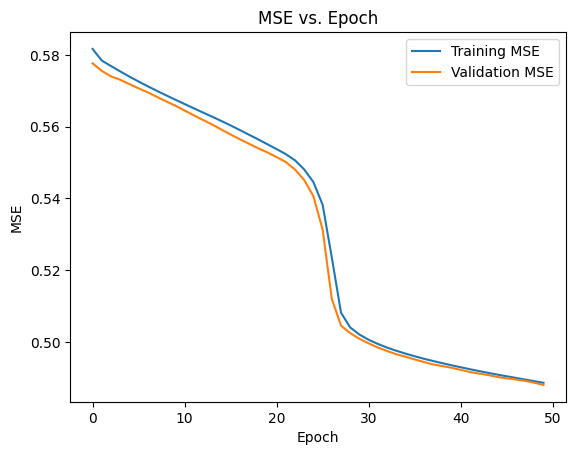

In [100]:
import matplotlib.pyplot as plt
#plt.plot(history.history['accuracy'], label='Training Accuracy')
#plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['mean_squared_error'], label='Training MSE')
plt.plot(history.history['val_mean_squared_error'], label='Validation MSE')

plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('MSE vs. Epoch')
plt.legend()
plt.show()

# MIN LOSS = 0.0128 c/fund 50epochs MSE
##         = 0.0118 s/fund 50epochs MSE
##         = 0.0039 s/fund 50epochs MSE m=4 d=6

In [101]:
# Assuming you have a validation dataset (val_dataset)
iterador = iter(val_dataset)
sample = next(iterador)
next_sample = next(iterador)
input_data = sample[0]  # Assuming your dataset provides input data as the first element
actual_values = sample[1]  # Assuming your dataset provides actual labels as the second element

# Predict using the model
predictions = model.predict(input_data)

16/16 [==============================] - 0s 1ms/step


Diferencias en error RMSE

In [102]:
from sklearn.metrics import mean_squared_error

# Vemos algunos valores
for e in val_dataset:
    for i in range(0, 4):
        print(e[1][i])
        print(predictions[i])
    break
    
# Veamos el MSE de los valores de G      
#RMSE_pred = mean_squared_error(actual_values, predictions, squared=False)
#RMSE_rand = mean_squared_error(actual_values, next_sample[1], squared=False)
#print(RMSE_pred, RMSE_rand)
#rint(RMSE_rand/RMSE_pred)
# Veamos los errores en términos de norma 2 (equiv a lo anterior)
if predictions.shape[1] == 1:
    norm_pred = np.mean(np.abs(predictions.T-actual_values))
    norm_rand = np.mean(np.abs(next_sample[1]-actual_values))
else:
    norm_pred = np.mean(np.linalg.norm(predictions-actual_values,ord=2, axis=1))
    norm_rand = np.mean(np.linalg.norm(next_sample[1]-actual_values,ord=2, axis=1))
print(norm_pred, norm_rand)
print(norm_rand / norm_pred)


tf.Tensor(
[0.52517579 4.49461811 3.51316755 3.25186979 2.82823035 4.90859745
 4.09653028 4.94807658 3.98540823 4.14701699 1.89579501 2.53848966
 2.11349942 2.36851627 2.16361422 1.33100052 1.7077039  2.47985038
 1.93070661 4.61080705 4.17449161 3.62170689 1.56263386 0.02672285
 3.14551549 2.26798428 4.66833984 4.54741258 4.42418824 0.08149483
 4.86934671 4.66972991 2.25683629 3.43542066 2.21662077 1.13014476], shape=(36,), dtype=float64)
[-0.14575237  4.364818    2.9028997   2.2962003   2.2852118   4.5491595
  3.6647387   4.8170714   2.6653087   3.7763739   2.161203    1.640496
  1.8409252   2.729893    2.317075    1.8677803   2.263486    2.1565652
  1.7816224   3.958267    4.097479    4.0564485   2.0184774   0.91449517
  4.0390215   2.4177065   4.2566657   3.6647644   3.4208655   0.36926395
  4.0546794   4.1669183   2.3673136   3.1990275   2.2383099   1.10644   ]
tf.Tensor(
[0.56100989 1.81810926 1.91168697 1.28918402 3.95191362 3.71677968
 0.03976157 4.26290002 4.90837264 2.64664171

Análisis rho2

In [103]:
# Vemos algunos valores
for e in val_dataset:
    # Caso constante
    if predictions.shape[1] == 1:
        g_arr = [np.ones((basis.m, basis.m))*g_seed for g_seed in predictions]
    # Caso Gaussiano
    elif predictions.shape[1] == 2:
        # Verificacion de rango de valores, la prediccion de sigma debe ser positiva
        for p in predictions:
            if p[0] < 0 or p[1] < 0:
                print(p)
        # Calculo de rho2 pred
        g_arr = gen_gauss_mat_np(predictions[:,0], predictions[:,1], basis.m)
    # Caso general
    else:
        triag = tfp.math.fill_triangular(predictions, upper=True)
        g_arr = triag + tf.transpose(triag, perm=[0,2,1])-tf.linalg.diag(tf.linalg.diag_part(triag))
        g_arr = g_arr.numpy()
    h_arr = two_body_hamiltonian_tf(t_basis, basis.m, en_batch, g_arr, rho_1_arrays, rho_2_arrays, k_indices_tf)
    ## Estados térmicos
    #state = thermal_state_tf(h_arr*beta) 
    state = tf.cast(state, dtype=tf.float32)
    ## Estados puros
    state = pure_state(h_arr)
    #rho_2_input = rho_2_tf(state, rho_2_arrays_tf)
    # Calculo de estadistica
    #rho_2_s = lambda x: [np.max(i) for i in np.linalg.eigvals(x)]
    rho_2_s = lambda x: np.sort(np.linalg.eigvals(x))
    rho_2_pred = rho_2_s(rho_2_tf(state, rho_2_arrays_kkbar_tf))
    rho_2_true = rho_2_s(e[0])
    rho_2_rand = rho_2_s(next_sample[0])
    # Printeamos algunos valores
    for i in range(0, 4):
        print("true: " + str(rho_2_true[i]))
        print("pred: " + str(rho_2_pred[i]))
    # Analisis RMSE
    #RMSE_pred = mean_squared_error(rho_2_true, rho_2_pred, squared=False)
    #RMSE_rand = mean_squared_error(rho_2_true, rho_2_rand, squared=False)
    #print(RMSE_pred, RMSE_rand)
    #print(RMSE_rand/RMSE_pred)
    norm_pred = np.mean(np.linalg.norm(rho_2_true-rho_2_pred,ord=2, axis=1))
    norm_rand = np.mean(np.linalg.norm(rho_2_true-rho_2_rand,ord=2, axis=1))
    print(norm_pred, norm_rand)
    print(norm_rand / norm_pred)
    break

# Veamos ahora en función de G
if predictions.shape[1] == 1:
    pred_ids = predictions.T.argsort()
    predictions_sort = predictions[pred_ids][0]
    G_true_sorted = e[1].numpy()[pred_ids].T
else:
    pred_ids = predictions[:,0].argsort()
    predictions_sort = predictions[:,0][pred_ids]
    G_true_sorted = e[1][:,0].numpy()[pred_ids]
G_err = np.abs(predictions_sort-G_true_sorted)
plt.plot(predictions_sort,G_err)


LinAlgError: Last 2 dimensions of the array must be square

In [286]:
m_size = basis.size
rho_1_pred = []
rho_1_actual = []
norm = []
norm_rand = []
printear =  False

for e in val_dataset:
    for i in range(0, 3 if printear else batch_size):
        # Valores actuales
        #h = e[1][i].numpy().reshape(basis.size,basis.size)
        h_true = gen_to_h(e[1][i], rho_1_arrays)
        #print(h) if printear else 0
        r = max(np.linalg.eigvals(e[0][i]))
        rho_1_actual.append(r)

        print(h_true) if printear else 0
        print(r) if printear else 0

        # Valores predichos
        #h = predictions[i].reshape(basis.size,basis.size)
        h_pred = gen_to_h(predictions[i], rho_1_arrays)
        beta = 1
        # Estado térmico
        state = thermal_state(h_pred, beta)
        # Estado puro
        #state = pure_state(h_pred)
        rho1 = np.array(rho_1(basis.d, state, rho_1_arrays))
        r = max(np.sort(linalg_d.eigvals(rho1).real))
        rho_1_pred.append(r)

        print(h_pred) if printear else 0
        print(r) if printear else 0
        

        # Normas
        norm.append(np.linalg.norm(h_true-h_pred, ord='fro'))
        print(f'Norma {norm[-1]}') if printear else 0
        ## Vamos a comparar con un h aleatorio
        size = basis.d*(basis.d+1)//2
        base = np.random.uniform(low=0, high=1.0, size=(size,))
        h_rand = gen_to_h(base, rho_1_arrays)
        norm_rand.append(np.linalg.norm(h_true-h_rand, ord='fro'))
        #print(f'Norma random {norm_rand[-1]}') if printear else 0
        print('') if printear else 0
        


    # e contiene todo el batch y nos basta con uno
    break

IndexError: tuple index out of range

In [ ]:
print(e[1][10])
predictions[10]

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

f=1
rho_1_actual = np.array(rho_1_actual)
rho_1_pred = np.array(rho_1_pred)
#print(mean_squared_error(rho_1_pred, rho_1_actual))

print('Rho1 based statistics')
print(np.mean(np.abs(rho_1_actual-rho_1_pred)))
print(np.mean(rho_1_actual)*f)
print('std')
print(np.std(rho_1_actual-rho_1_pred)*f)
print(np.std(rho_1_actual)*f)
print(np.std(rho_1_pred)*f)
plt.hist(np.array(rho_1_pred-rho_1_actual), bins=50)
plt.show()
print('H based statistics')
print(np.mean(norm), np.mean(norm_rand))
print(np.mean(norm_rand)/np.mean(norm))


# BEST: FACTOR 1/8 c/fund
## 500 epochs, 10M dataset
# BEST: FACTOR 1/9 s/fund
## 50 epochs, 5M dataset

In [ ]:
6.25/1.30

In [ ]:
# 25 epochs d = m*2
res = {}
res[5] = 35/8.19 
res[4] = 15/2.47
res[3] = 6.2/1.73

In [ ]:
print(res)

In [ ]:
# Get the weights of all dense layers in the model
dense_weights = []
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Dense):
        weights = layer.get_weights()
        if len(weights) > 0:
            dense_weights.append(weights[0])

# Visualize the weights of each dense layer
for i, weights in enumerate(dense_weights):
    plt.figure()
    plt.imshow(weights, cmap='viridis', aspect='auto')
    plt.colorbar()
    plt.title(f"Dense Layer {i+1} Weights Visualization")
    plt.show()


In [ ]:
rho_2_arrays[9,0,0,9]

0.0

In [ ]:
# Genera las matrices de rho2
def rho_2_gen(basis, mll_basis, t_basis):
    size = t_basis.size
    s = basis.size
    # La entrada i, j contiene C_j^\dag C_i    i, j \in t_basis
    mat = np.empty((size, size, s, s), dtype=np.float32)
    for i, v in enumerate(t_basis.base):
        for j, w in enumerate(t_basis.base):
            c_i = b_gen(basis, mll_basis, rep_to_exi(v))
            cdag_j = bd_gen(mll_basis, basis, rep_to_exi(w))
            mat[i, j, :, :] = np.dot(cdag_j, c_i)
            if mat[i,j,0,9] != 0:
                print(v,w)

    return mat

r = rho_2_gen(basis, basis_m2, t_basis)
r[9,0,0,9]

[0 0 0 0 1 1] [0 1 1 0 0 0]


0.0

In [ ]:
print(b_gen(basis, mll_basis, rep_to_exi([0,0,0,1,1,0])))

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [ ]:
b

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1.]], dtype=float32)

In [ ]:
basis.base

array([[1, 1, 1, 0, 0, 0],
       [1, 1, 0, 1, 0, 0],
       [1, 1, 0, 0, 1, 0],
       [1, 1, 0, 0, 0, 1],
       [1, 0, 1, 1, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 0, 1],
       [1, 0, 0, 1, 1, 0],
       [1, 0, 0, 1, 0, 1],
       [1, 0, 0, 0, 1, 1],
       [0, 1, 1, 1, 0, 0],
       [0, 1, 1, 0, 1, 0],
       [0, 1, 1, 0, 0, 1],
       [0, 1, 0, 1, 1, 0],
       [0, 1, 0, 1, 0, 1],
       [0, 1, 0, 0, 1, 1],
       [0, 0, 1, 1, 1, 0],
       [0, 0, 1, 1, 0, 1],
       [0, 0, 1, 0, 1, 1],
       [0, 0, 0, 1, 1, 1]])

In [ ]:
col = 1
b = b_gen(basis, mll_basis, rep_to_exi([0,0,0,1,1,0]))
print(b.shape)
for x in range(0,b.shape[1]):
    if b[col,x] != 0:
        ind = x
        break
else:
    ind = NaN

print([basis.base[ind]], mll_basis.base[col])

(6, 20)
[array([0, 1, 0, 1, 1, 0])] [0 1 0 0 0 0]


In [ ]:
m = 3
d = 2*m
basis = fixed_basis(m, d)
t_basis = fixed_basis(2, d)
basis_m1 = fixed_basis(m-1, d)
basis_m2 = fixed_basis(m-2, d)
ml_basis = basis_m1
mll_basis = basis_m2
rho_1_arrays = rho_1_gen(basis)
rho_2_arrays = rho_2_gen(basis, mll_basis, t_basis)

In [ ]:
t_basis = fixed_basis(2, d)
mll_basis = fixed_basis(basis.m-2, d)
rho_1_arrays = rho_1_gen(basis)
rho_2_arrays = rho_2_gen(basis, mll_basis, t_basis)

In [ ]:
def two_body_hamiltonian(t_basis_size, m, energy, G, rho_1_arrays, rho_2_arrays):
    # Creamos la mat diagonal de d*d con los elementos de energy
    # cada uno de estos, se contraen con los elementos de rho_1_arrays
    # la mat energy contiene las energias de cada termino c^\dag_k c_k para k kbar (iguales)
    # por ello los elementos se repiten 
    energy_matrix = np.diagflat(np.kron(energy, np.ones(2)))
    
    # Construimos la mat de energía
    h0 = np.sum(energy_matrix[:, :, np.newaxis, np.newaxis] * rho_1_arrays[:, :, :, :], axis=(0, 1))

    # Pasamos ahora a la matrix de interacción con la misma estrategia
    # dada G que indica la interacción entre los pares k' k'bar k kbar 
    # (que son elementos particulares de t_basis)
    # transladamos estos coeficientes a una matriz en t_basis
    # y multiplicamos por rho_2_arrays
    
    # Primero determinamos, dada t_basis, cuales son los indices de pares kkbar
    offset = 4*m+1
    indices = [-(k-1)*(2*k-offset) for k in range(1,m+1)] # Lo saque de Mathmatica, vos confia
    i, j = np.meshgrid(indices, indices, indexing='ij') # Lo usamos para rellenar la mat deseada
    
    # Contruimos la mat que contraeremos con rho_2_arrays
    mat = np.zeros((t_basis_size, t_basis_size))
    mat[i, j] = G

    hi = -np.sum(mat[:, :, np.newaxis, np.newaxis] * rho_2_arrays[:, :, :, :], axis=(0, 1))

    return (h0, hi)


In [ ]:
(h02,hi2) = two_body_hamiltonian(t_basis.size, m, [0,1,2], np.ones((3,3)), rho_1_arrays, rho_2_arrays)

In [ ]:
rho_2_arrays

array([[[[1., 0., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 0., 1., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
    

In [ ]:
print(rho_2_arrays[9,0,0,9])

0.0


In [ ]:
import numpy as np
rho_1_arrays = rho_1_gen(basis)

A = np.array([0, 1, 2])  # Your list with d elements

# Create a diagonal matrix with each element repeated twice
result_matrix = np.diagflat(np.kron(A, np.ones(2)))

print(result_matrix)
np.kron(A, np.ones(2))

mat = np.zeros((basis.size, basis.size))
for i in range(0,2*d):
    for j in range(0, 2*d):
        mat += result_matrix[i,j] * rho_1_arrays[i,j,:,:]


[1 1 0 0 1 1 1 1 0 0 0 0]
[1 1 0 0 1 1 0 0 1 1 0 0]
[1 1 0 0 1 1 0 0 0 0 1 1]
[1 1 0 0 0 0 1 1 1 1 0 0]
[1 1 0 0 0 0 1 1 0 0 1 1]
[1 1 0 0 0 0 0 0 1 1 1 1]
[1 1 0 0 1 1 1 1 0 0 0 0]
[1 1 0 0 1 1 0 0 1 1 0 0]
[1 1 0 0 1 1 0 0 0 0 1 1]
[1 1 0 0 0 0 1 1 1 1 0 0]
[1 1 0 0 0 0 1 1 0 0 1 1]
[1 1 0 0 0 0 0 0 1 1 1 1]
[1 1 1 1 0 0 1 1 0 0 0 0]
[1 1 1 1 0 0 0 0 1 1 0 0]
[1 1 1 1 0 0 0 0 0 0 1 1]
[1 1 0 0 0 0 1 1 1 1 0 0]
[1 1 0 0 0 0 1 1 0 0 1 1]
[1 1 0 0 0 0 0 0 1 1 1 1]
[1 1 1 1 0 0 1 1 0 0 0 0]
[1 1 1 1 0 0 0 0 1 1 0 0]
[1 1 1 1 0 0 0 0 0 0 1 1]
[1 1 0 0 0 0 1 1 1 1 0 0]
[1 1 0 0 0 0 1 1 0 0 1 1]
[1 1 0 0 0 0 0 0 1 1 1 1]
[1 1 1 1 1 1 0 0 0 0 0 0]
[1 1 1 1 0 0 0 0 1 1 0 0]
[1 1 1 1 0 0 0 0 0 0 1 1]
[1 1 0 0 1 1 0 0 1 1 0 0]
[1 1 0 0 1 1 0 0 0 0 1 1]
[1 1 0 0 0 0 0 0 1 1 1 1]
[1 1 1 1 1 1 0 0 0 0 0 0]
[1 1 1 1 0 0 0 0 1 1 0 0]
[1 1 1 1 0 0 0 0 0 0 1 1]
[1 1 0 0 1 1 0 0 1 1 0 0]
[1 1 0 0 1 1 0 0 0 0 1 1]
[1 1 0 0 0 0 0 0 1 1 1 1]
[1 1 1 1 1 1 0 0 0 0 0 0]
[1 1 1 1 0 0 1 1 0 0 0 0]
[1 1 1 1 0 0

IndexError: index 6 is out of bounds for axis 1 with size 6

In [ ]:
mat = np.sum(result_matrix[:, :, np.newaxis, np.newaxis] * rho_1_arrays[:, :, :, :], axis=(0, 1))

In [ ]:
h0 == mat

In [ ]:
d = 3
t_basis = fixed_basis(2, 2*d)
basis = fixed_basis(d, 2*d)
size = t_basis.size
#basis = fixed_basis(d, 2*d)
diag_elem = []
for x in t_basis.base:
    if all([x[i] == x[i+1] for i in range(0, 2*d, 2)]):
        print(x)
        diag_elem.append(t_basis.rep_to_index(x))

print(diag_elem)
# Veamos el GALERAZO de Wolfram
n = 4*d+1
print([-(k-1)*(2*k-n) for k in range(1,d+1)])


[1 1 0 0 0 0]
[0 0 1 1 0 0]
[0 0 0 0 1 1]
[0, 9, 14]
[0, 9, 14]


In [ ]:
m2_basis = fixed_basis(2, d)
print(m2_basis.size)
nm2_basis = fixed_basis(basis.m-2, d)
print(nm2_basis.base)


In [ ]:
W = np.array([[1,2,3],[4,5,6],[7,8,9]])
index = [0,9,14]
mat = np.zeros((size,size))
for i in range(0,3):
    for j in range(0,3):
        mat[index[i], index[j]] = W[i,j]

In [ ]:
import numpy as np
rho_2_arrays = rho_2_gen(basis, nm2_basis, m2_basis)
#rho_2_arrays_tf = tf.constant(rho_2_arrays, dtype=tf.float32)

W = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
W = np.ones((3,3))
index = [0, 9, 14]
size = 15  # Assuming size is the size of the matrix

# Create a meshgrid of indices
i, j = np.meshgrid(index, index, indexing='ij')

# Use the meshgrid indices to assign values from W to the specified positions in mat
mat = np.zeros((size, size))
mat[i, j] = W

# La mat... mat corresponde a los coeficientes en t_basis
inte = np.zeros((basis.size, basis.size))
for i in range(0, t_basis.size):
    for j in range(0, t_basis.size):
        inte += - mat[i, j] * rho_2_arrays[i,j,:,:]


In [ ]:
inte == hi

In [ ]:
m = 3
basis = fixed_basis(m, d)
basis_m1 = fixed_basis(m-1, d)
basis_m2 = fixed_basis(m-2, d)

from numba import njit

# Parametros hamiltoniano
e = 1
eps = 0
e0 = np.zeros(2*d)
eigenspace_tol = 0.0001
for k in range(0, d):
    r = random.random() * eps * 0
    e0[2*k] = k*e+r
    e0[2*k+1] = k*e+r

@njit(parallel=True)
def base_hamiltonian_aux(basis, size, d, basis_m1, basis_m2):
    # Construccion de H
    d = d//2
    h0 = np.zeros((size,size), dtype=np.float32)
    for k in prange(0,2*d):
        h0 += e0[k] * np.dot(bd_aux(basis_m1, basis, k),b_aux(basis, basis_m1, k))
    hi = np.zeros((size, size), dtype=np.float32)
    for k in prange(0,d):
        for kb in prange(0,d):
            bd_terms = np.dot(bd_aux(basis_m1, basis, 2*k),bd_aux(basis_m2, basis_m1, 2*k+1))
            b_terms = np.dot(b_aux(basis_m1, basis_m2, 2*kb+1),b_aux(basis, basis_m1, 2*kb))
            hi += -1*np.dot(bd_terms,b_terms)

    return (h0, hi)

def base_hamiltonian(basis, basis_m1, basis_m2):
    return base_hamiltonian_aux(basis.base, basis.size, basis.d, basis_m1.base, basis_m2.base)

h0, hi = base_hamiltonian(basis, basis_m1, basis_m2)

Testeo barrido en G código anterior

In [ ]:
num = 50
g_range = np.linspace(0.01,5,num)
rho_range= {}
gpu_batch_size = 2

# Construccion de parametros y matrices auxiliares
#rho1_size = m1_basis.size
rho2_size = m2_basis.size
rho2kkbar_size = basis.m
fund_size = basis.size
hamil_base_size = basis.d*(basis.d+1)//2
rho_1_arrays = rho_1_gen(basis)
rho_1_arrays_tf = tf.constant(rho_1_arrays, dtype=tf.float32)
rho_2_arrays = rho_2_gen(basis, nm2_basis, m2_basis)
rho_2_arrays_tf = tf.constant(rho_2_arrays, dtype=tf.float32)
rho_2_arrays_kkbar = rho_2_kkbar_gen(t_basis, rho_2_arrays)
rho_2_arrays_kkbar_tf = tf.constant(rho_2_arrays_kkbar, dtype=tf.float32)
k_indices = get_kkbar_indices(t_basis)
k_indices_tf = gen_update_indices(t_basis, gpu_batch_size)

batch_size = 2
indices = tf.constant(get_kkbar_indices(t_basis))
indices_tf = gen_update_indices(t_basis, batch_size)
en_batch = [np.arange(0, basis.m) for _ in range(0,batch_size)]
G_batched = [np.ones((basis.m,basis.m)) for _ in range(0, batch_size)]

t = two_body_hamiltonian_tf(t_basis, basis.m, en_batch, G_batched, rho_1_arrays, rho_2_arrays, indices_tf)
(h0, hi) = (t[0][0].numpy(), t[1][0].numpy())



In [ ]:
def compute_g(g):
    #print(g)
    G_batched = [g * np.ones((basis.m,basis.m)) for _ in range(0, batch_size)]
    t = two_body_hamiltonian_tf(t_basis, basis.m, en_batch, G_batched, rho_1_arrays, rho_2_arrays, indices_tf)
    state = pure_state(t)
    #print(fund)
    #print('rho')
    #Toda la matriz
    rho = rho_2_tf(state, rho_2_arrays_kkbar_tf)
    #Solo el bloque kkbar
    #rho = rho_2_kkbar(basis, fund, ml_basis, mll_basis, t_basis)
    #Rho1
    #rho = rho_1(basis, fund).todense()
    r = np.sort(linalg_d.eigvals(rho[0]).real)
    #print(r)
    return (g, r)

# Version sincrónica
rho_range = {}

for g in g_range:
    print(g)
    rho_range[g] = compute_g(g)


0.01
0.11183673469387755
0.2136734693877551
0.31551020408163266
0.4173469387755102
0.5191836734693878
0.6210204081632653
0.7228571428571429
0.8246938775510204
0.926530612244898
1.0283673469387755
1.130204081632653
1.2320408163265306
1.3338775510204082
1.4357142857142857
1.5375510204081633
1.6393877551020408
1.7412244897959184
1.843061224489796
1.9448979591836735
2.046734693877551
2.1485714285714286
2.250408163265306
2.3522448979591832
2.454081632653061
2.555918367346939
2.657755102040816
2.7595918367346934
2.861428571428571
2.963265306122449
3.0651020408163263
3.1669387755102036
3.2687755102040814
3.370612244897959
3.4724489795918365
3.574285714285714
3.6761224489795916
3.7779591836734694
3.8797959183673467
3.981632653061224
4.083469387755102
4.18530612244898
4.287142857142857
4.388979591836734
4.490816326530612
4.59265306122449
4.694489795918367
4.7963265306122445
4.898163265306122
5.0


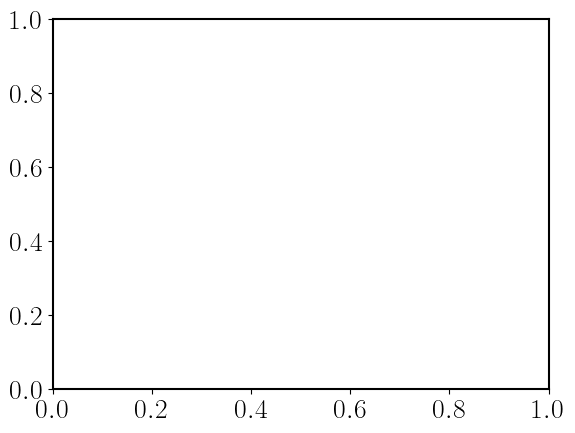

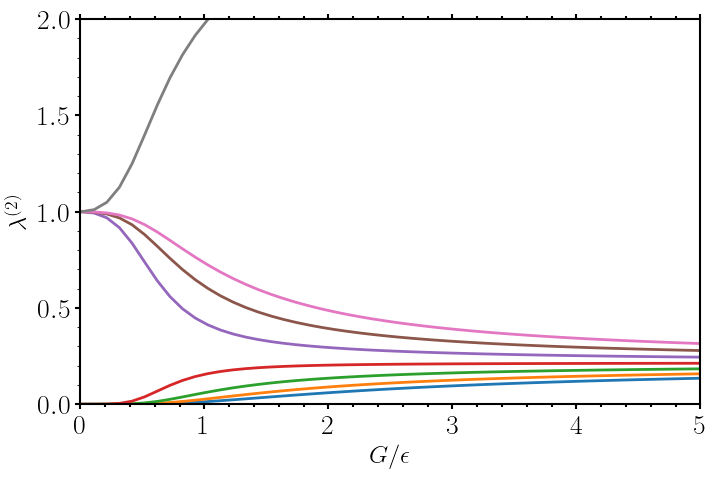

PermissionError: [Errno 13] Permission denied: 'filename.png'

<Figure size 640x480 with 0 Axes>

In [ ]:
# Ploteamos
rho_range = dict(rho_range)
rho_range = dict(sorted(rho_range.items()))
x_axis = list(g_range)
values = list(rho_range.items())
size = len(values[0][1])
num = 50
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

# Plot using matplotlib
# Use LaTeX to format all text

plt.rcParams['text.usetex'] = True
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['axes.linewidth'] = 1.5

plt.cla()
plt.figure(figsize=(8, 5))
#%matplotlib qt
%matplotlib inline 
for k in range(1,size):
    plt.plot(x_axis, [values[j][1][k] for j in range(0,num)], linewidth=2)

plt.xlabel(r'$G/\epsilon$', fontsize=18)
plt.ylabel(r'$\lambda^{(2)}$', fontsize=18)
plt.xlim(0, 5)  # Set x-axis limits from 0 to 6
plt.ylim(0, 2)  # Set y-axis limits from 5 to 12

#matplotlib.use('Agg')
#matplotlib.use('GTK3Agg')

plt.tick_params(axis='x', which='both', bottom=True, top=True, labelbottom=True)

# Enable minor ticks on the x-axis
plt.minorticks_on()

# Customize the appearance of minor ticks on the x-axis
plt.tick_params(axis='x', which='minor', width=1.5)
plt.tick_params(axis='x', which='major', width=1.5)
plt.tick_params(axis='y', which='major', width=1.5)

plt.show()
matplotlib.pyplot.savefig('filename.png')
